<a href="https://colab.research.google.com/github/JSA-V/freeCodeCamp-projects/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-11-20 16:18:54--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.007s  

2022-11-20 16:18:54 (47.2 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-11-20 16:18:54--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
# read data

train=pd.read_csv('train-data.tsv', sep='\t',names=['label','SMS'])
train['label'].replace(['ham','spam'],[0,1],inplace=True)
test=pd.read_csv('valid-data.tsv', sep='\t',names=['label','SMS'])
test['label'].replace(['ham','spam'],[0,1],inplace=True)

train_data,train_labels=train['SMS'].to_numpy(), train['label'].to_numpy()
test_data,test_labels=test['SMS'].to_numpy(), test['label'].to_numpy()


print(train_data.shape,test_data.shape,test_data.shape[0]/train_data.shape[0])
 
train=tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test=tf.data.Dataset.from_tensor_slices((test_data, test_labels))


(4179,) (1392,) 0.3330940416367552


In [ ]:
# shuffle and create batches

BUFFER_SIZE = 100
BATCH_SIZE = 32

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# vectorization process

from keras.layers import TextVectorization

MAX_SEQUENCE_LENGTH = 250

vectorization_layer = TextVectorization(
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
vectorization_layer.adapt(train.map(lambda SMS, label: SMS))
vocab = np.array(vectorization_layer.get_vocabulary())# learn vocabulary
VOCAB_SIZE=len(vocab) 

example="Hello, I'm Mickey Mouse"
encoded_example=vectorization_layer(example).numpy()[:4]


print("Original: ", example)
print("Round-trip: ", " ".join(vocab[encoded_example]))
print()

Original:  Hello, I'm Mickey Mouse
Round-trip:  hello im [UNK] [UNK]



In [ ]:
# model

model = tf.keras.Sequential([
    vectorization_layer,
    tf.keras.layers.Embedding(
        VOCAB_SIZE+1,
        64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1,activation="sigmoid")])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#             optimizer=tf.keras.optimizers.Adam(1e-4),
#             metrics=['accuracy'])

history = model.fit(train, epochs=10,validation_data=test,validation_steps=30)


Epoch 1/10
131/131 [==============================] - 19s 58ms/step - loss: 0.6181 - accuracy: 0.8533 - val_loss: 0.4840 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 4s 32ms/step - loss: 0.3454 - accuracy: 0.8823 - val_loss: 0.2119 - val_accuracy: 0.9323
Epoch 3/10
131/131 [==============================] - 5s 35ms/step - loss: 0.1385 - accuracy: 0.9754 - val_loss: 0.0879 - val_accuracy: 0.9833
Epoch 4/10
131/131 [==============================] - 4s 31ms/step - loss: 0.0636 - accuracy: 0.9883 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 5/10
131/131 [==============================] - 4s 32ms/step - loss: 0.0379 - accuracy: 0.9935 - val_loss: 0.0525 - val_accuracy: 0.9865
Epoch 6/10
131/131 [==============================] - 4s 32ms/step - loss: 0.0252 - accuracy: 0.9962 - val_loss: 0.0532 - val_accuracy: 0.9844
Epoch 7/10
131/131 [==============================] - 4s 32ms/step - loss: 0.0170 - accuracy: 0.9983 - val_loss: 0.0551 - val_accuracy: 0.982

44/44 [==============================] - 0s 7ms/step - loss: 0.0563 - accuracy: 0.9828


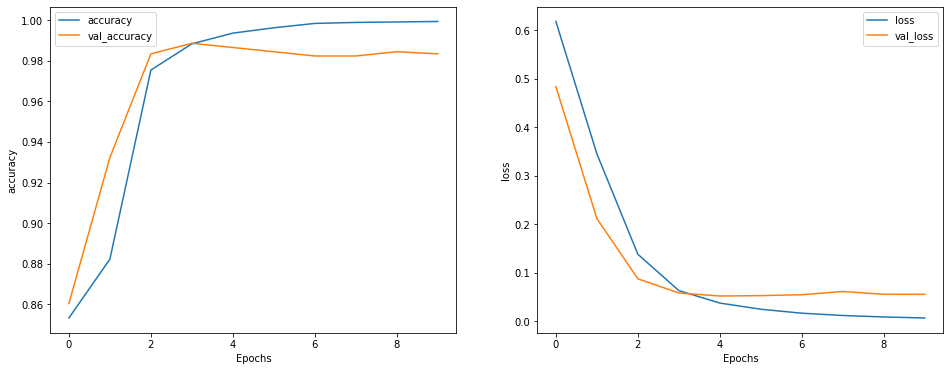

In [ ]:
# history plot

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

test_loss, test_acc = model.evaluate(test)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p=model.predict(np.array([pred_text]))[0][0]
  return [p]+['ham' if p <0.5 else 'spam']

pred_text = "how are you doing today?"
prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 2s 2s/step
[0.00083001255, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    #print(prediction[0])
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 16ms/step
You passed the challenge. Great job!
